In [1]:
import pandas as pd
df = pd.read_csv('belgian_2024_race_laps.csv')
df


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 00:57:07.735000,HAM,44,0 days 00:01:52.700000,1.0,1.0,NaN,NaN,NaN,0 days 00:00:49.406000,...,True,Mercedes,0 days 00:55:14.764000,2024-07-28 13:03:52.742,1,2.0,False,NaN,False,False
1,0 days 00:58:57.584000,HAM,44,0 days 00:01:49.849000,2.0,1.0,NaN,NaN,0 days 00:00:31.284000,0 days 00:00:49.211000,...,True,Mercedes,0 days 00:57:07.735000,2024-07-28 13:05:45.713,1,2.0,False,NaN,False,True
2,0 days 01:00:46.693000,HAM,44,0 days 00:01:49.109000,3.0,1.0,NaN,NaN,0 days 00:00:31.215000,0 days 00:00:48.486000,...,True,Mercedes,0 days 00:58:57.584000,2024-07-28 13:07:35.562,1,1.0,False,NaN,False,True
3,0 days 01:02:36.501000,HAM,44,0 days 00:01:49.808000,4.0,1.0,NaN,NaN,0 days 00:00:31.754000,0 days 00:00:48.605000,...,True,Mercedes,0 days 01:00:46.693000,2024-07-28 13:09:24.671,1,1.0,False,NaN,False,True
4,0 days 01:04:25.877000,HAM,44,0 days 00:01:49.376000,5.0,1.0,NaN,NaN,0 days 00:00:31.592000,0 days 00:00:48.320000,...,True,Mercedes,0 days 01:02:36.501000,2024-07-28 13:11:14.479,1,1.0,False,NaN,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
836,0 days 02:08:02.442000,RUS,63,0 days 00:01:47.631000,40.0,2.0,NaN,NaN,0 days 00:00:30.989000,0 days 00:00:47.555000,...,True,Mercedes,0 days 02:06:14.811000,2024-07-28 14:14:52.789,1,1.0,False,NaN,False,True
837,0 days 02:09:50.196000,RUS,63,0 days 00:01:47.754000,41.0,2.0,NaN,NaN,0 days 00:00:30.926000,0 days 00:00:47.796000,...,True,Mercedes,0 days 02:08:02.442000,2024-07-28 14:16:40.420,1,1.0,False,NaN,False,True
838,0 days 02:11:37.661000,RUS,63,0 days 00:01:47.465000,42.0,2.0,NaN,NaN,0 days 00:00:31.014000,0 days 00:00:47.525000,...,True,Mercedes,0 days 02:09:50.196000,2024-07-28 14:18:28.174,1,1.0,False,NaN,False,True
839,0 days 02:13:24.962000,RUS,63,0 days 00:01:47.301000,43.0,2.0,NaN,NaN,0 days 00:00:30.990000,0 days 00:00:47.479000,...,True,Mercedes,0 days 02:11:37.661000,2024-07-28 14:20:15.639,1,1.0,False,NaN,False,True


In [2]:
df['LapTime'] = pd.to_timedelta(df['LapTime'], errors='coerce')
df['LapTimeSeconds'] = df['LapTime'].dt.total_seconds()

In [3]:
voltas_completadas = df.groupby('Driver')['LapNumber'].max()
num_voltas_corrida = 44  # exemplo para Abu Dhabi 2024
limite_conclusao = 0.9 * num_voltas_corrida

concluiu = voltas_completadas >= limite_conclusao

df_features = pd.DataFrame({
    'Driver': voltas_completadas.index,
    'VoltasCompletadasDadosBrutos': voltas_completadas.values,
    'Concluiu': concluiu.values
})

# Resetar o índice para manter um DataFrame limpo
df_features.reset_index(drop=True, inplace=True)

In [4]:
import pandas as pd
import numpy as np

# 1. Criar pits_df com voltas que tem PitInTime ou PitOutTime (opcional, só para pegar dados importantes)
pits_df = df[df['PitInTime'].notna() | df['PitOutTime'].notna()]
pits_df = pits_df[['Driver', 'LapNumber', 'PitInTime', 'PitOutTime', 'Compound', 'TyreLife', 'Stint']]
pits_df = pits_df.sort_values(['Driver', 'LapNumber']).reset_index(drop=True)

# 2. Número de paradas no box por piloto = número de stints - 1
num_stints = df.groupby('Driver')['Stint'].nunique()
pit_counts = (num_stints - 1).rename('NumParadasBox')

# 3. Volta do primeiro pit stop por piloto — pegar a menor volta onde mudou o stint (ou a primeira volta do segundo stint)
# Para isso, pegar a volta mínima para cada piloto onde o stint é > 1
primeiro_pit = df[df['Stint'] > 1].groupby('Driver')['LapNumber'].min().rename('VoltaPrimeiroPit')

# 4. Duração média dos stints por piloto (número médio de voltas por stint)
stint_dur = df.groupby(['Driver', 'Stint']).size().groupby('Driver').mean().rename('DuracaoMediaStint')

# 5. Proporção de voltas por tipo de pneu
voltas_totais = df.groupby('Driver').size()

prop_soft = df[df['Compound'] == 'SOFT'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasMacios')
prop_medium = df[df['Compound'] == 'MEDIUM'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasMedios')
prop_hard = df[df['Compound'] == 'HARD'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasDuros')

# 6. Juntar tudo num DataFrame
df_pit_features = pd.concat([
    pit_counts,
    primeiro_pit,
    stint_dur,
    prop_soft,
    prop_medium,
    prop_hard
], axis=1).reset_index()

# Substituir NaNs por 0 para pilotos sem dados em algumas colunas
df_pit_features.fillna({
    'NumParadasBox': 0,
    'VoltaPrimeiroPit': 0,
    'DuracaoMediaStint': 0,
    'PropVoltasMacios': 0,
    'PropVoltasMedios': 0,
    'PropVoltasDuros': 0
}, inplace=True)

print(df_pit_features.head())


  Driver  NumParadasBox  VoltaPrimeiroPit  DuracaoMediaStint  \
0    ALB              2               9.0          14.666667   
1    ALO              1              14.0          22.000000   
2    BOT              2              12.0          14.666667   
3    GAS              2              10.0          14.666667   
4    HAM              2              12.0          14.666667   

   PropVoltasMacios  PropVoltasMedios  PropVoltasDuros  
0               0.0          0.522727         0.477273  
1               0.0          1.000000         0.000000  
2               0.0          0.454545         0.545455  
3               0.0          0.204545         0.795455  
4               0.0          0.250000         0.750000  


In [5]:
pits_df

,Driver,LapNumber,PitInTime,PitOutTime,Compound,TyreLife,Stint
0,ALB,8.0,0 days 01:10:08.481000,NaN,MEDIUM,8.0,1.0
1,ALB,9.0,NaN,0 days 01:10:31.974000,MEDIUM,1.0,2.0
2,ALB,23.0,0 days 01:37:56.919000,NaN,MEDIUM,15.0,2.0
3,ALB,24.0,NaN,0 days 01:38:19.799000,HARD,1.0,3.0
4,ALO,13.0,0 days 01:19:21.309000,NaN,MEDIUM,13.0,1.0
...,...,...,...,...,...,...,...
64,VER,10.0,0 days 01:13:44.188000,NaN,MEDIUM,10.0,1.0
65,VER,11.0,NaN,0 days 01:14:07.325000,HARD,1.0,2.0
66,VER,28.0,0 days 01:46:33.171000,NaN,HARD,18.0,2.0
67,VER,29.0,NaN,0 days 01:46:56.099000,MEDIUM,1.0,3.0


In [6]:
df_pit_features

,Driver,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,2,9.0,14.666667,0.000000,0.522727,0.477273
1,ALO,1,14.0,22.000000,0.000000,1.000000,0.000000
2,BOT,2,12.0,14.666667,0.000000,0.454545,0.545455
3,GAS,2,10.0,14.666667,0.000000,0.204545,0.795455
4,HAM,2,12.0,14.666667,0.000000,0.250000,0.750000
5,HUL,2,8.0,14.666667,0.000000,0.704545,0.295455
6,LEC,2,13.0,14.666667,0.000000,0.272727,0.727273
7,MAG,1,18.0,22.000000,0.000000,0.386364,0.613636
8,NOR,2,16.0,14.666667,0.000000,0.340909,0.659091
9,OCO,2,13.0,14.666667,0.000000,0.272727,0.727273


In [7]:
df = df[df['IsAccurate']]


In [8]:
df['IsAccurate'].value_counts()


,count
IsAccurate,
True,751


In [9]:
df['Driver'].value_counts()


,count
Driver,
MAG,41
TSU,41
STR,41
ALO,41
RUS,41
LEC,39
PIA,39
HAM,39
VER,39


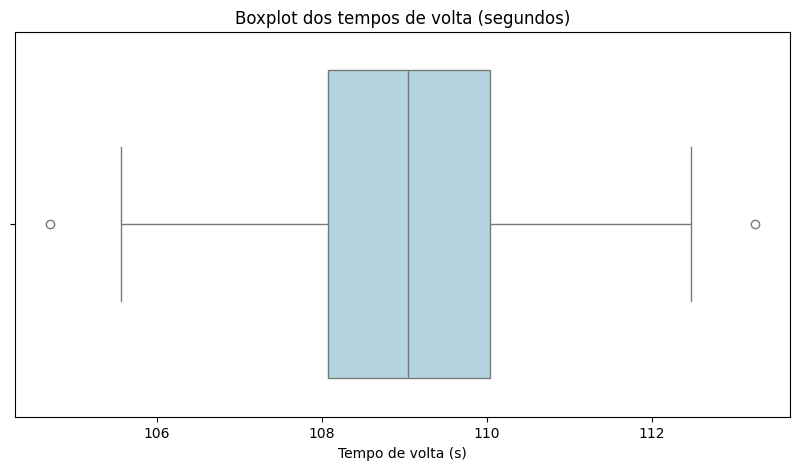

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(x=df['LapTimeSeconds'], color='lightblue')
plt.title('Boxplot dos tempos de volta (segundos)')
plt.xlabel('Tempo de volta (s)')
plt.show()


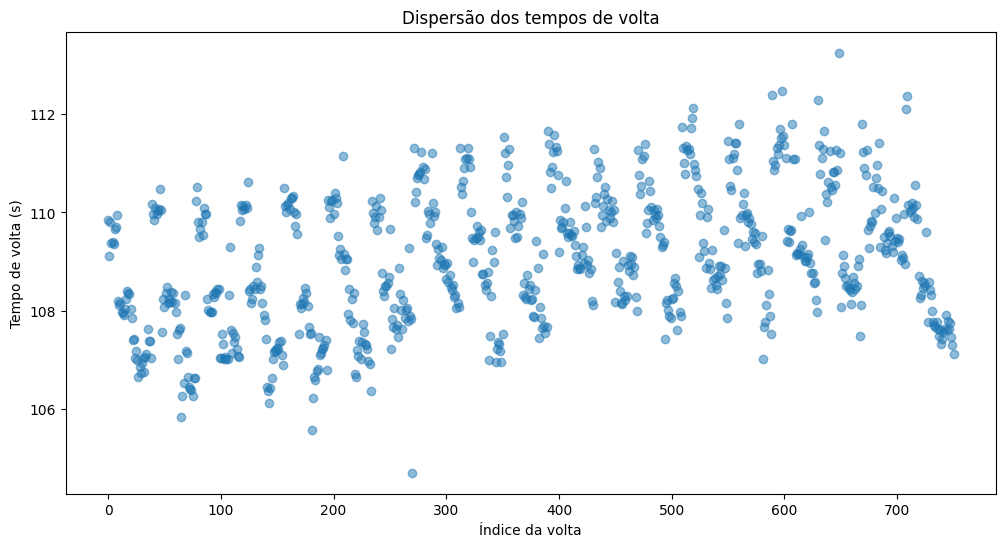

In [11]:
plt.figure(figsize=(12, 6))
plt.scatter(range(len(df)), df['LapTimeSeconds'], alpha=0.5)
plt.title('Dispersão dos tempos de volta')
plt.xlabel('Índice da volta')
plt.ylabel('Tempo de volta (s)')
plt.show()


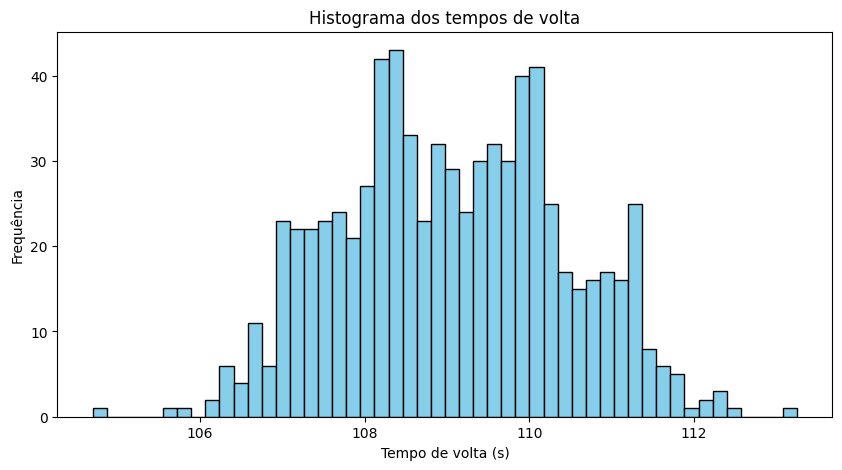

In [12]:
plt.figure(figsize=(10, 5))
plt.hist(df['LapTimeSeconds'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histograma dos tempos de volta')
plt.xlabel('Tempo de volta (s)')
plt.ylabel('Frequência')
plt.show()


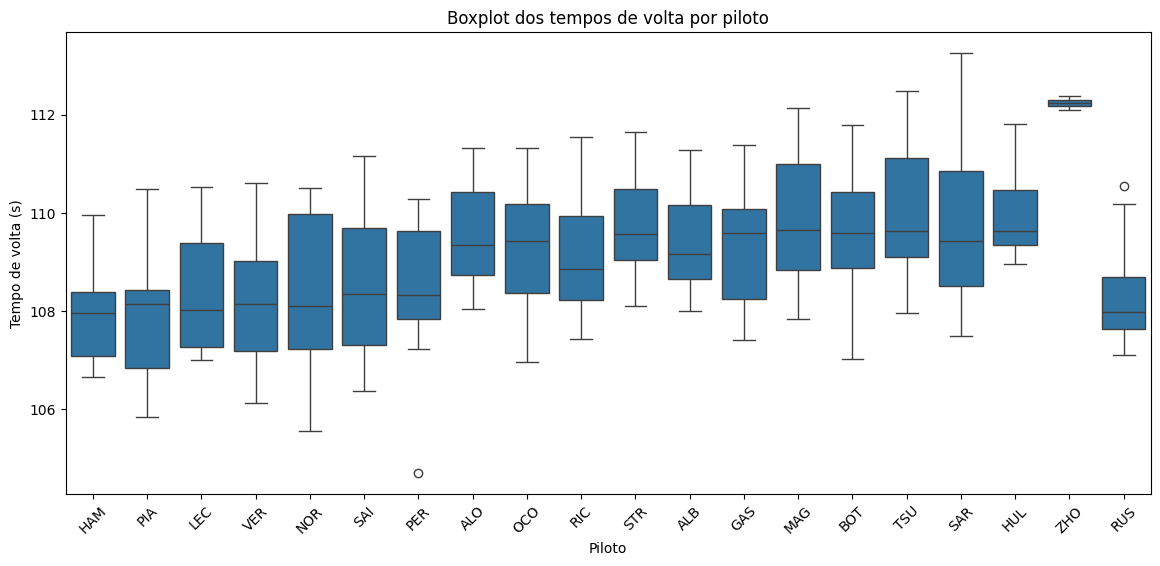

In [13]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='Driver', y='LapTimeSeconds', data=df)
plt.title('Boxplot dos tempos de volta por piloto')
plt.xlabel('Piloto')
plt.ylabel('Tempo de volta (s)')
plt.xticks(rotation=45)
plt.show()


In [14]:
menor_volta_por_piloto = df.groupby('Driver')['LapTime'].min().sort_values()
print(menor_volta_por_piloto)


Driver
PER   0 days 00:01:44.701000
NOR   0 days 00:01:45.563000
PIA   0 days 00:01:45.840000
VER   0 days 00:01:46.128000
SAI   0 days 00:01:46.364000
HAM   0 days 00:01:46.653000
OCO   0 days 00:01:46.957000
LEC   0 days 00:01:47.013000
BOT   0 days 00:01:47.019000
RUS   0 days 00:01:47.113000
GAS   0 days 00:01:47.418000
RIC   0 days 00:01:47.435000
SAR   0 days 00:01:47.490000
MAG   0 days 00:01:47.848000
TSU   0 days 00:01:47.969000
ALB   0 days 00:01:47.996000
ALO   0 days 00:01:48.051000
STR   0 days 00:01:48.105000
HUL   0 days 00:01:48.954000
ZHO   0 days 00:01:52.099000
Name: LapTime, dtype: timedelta64[ns]


In [15]:
year = 2024
grand_prix = 'Belgica'
race_date = '2024-07-28'  # ex: usar o dado do evento ou da sessão

# Calcular métricas por piloto (como antes)
consistency_df = df.groupby('Driver')['LapTimeSeconds'].agg([
    'count',
    'mean',
    'std',
    'min',
    'max',
    'median'
]).rename(columns={
    'count': 'NumVoltas',
    'mean': 'MediaTempo',
    'std': 'DesvioPadrao',
    'min': 'MelhorVolta',
    'max': 'PiorVolta',
    'median': 'MedianaTempo'
})

consistency_df['RangeTempo'] = consistency_df['PiorVolta'] - consistency_df['MelhorVolta']

# Adicionar colunas fixas
consistency_df['Year'] = year
consistency_df['GrandPrix'] = grand_prix
consistency_df['RaceDate'] = race_date

# Resetar índice para 'Driver' virar coluna normal
consistency_df = consistency_df.reset_index()


In [16]:
consistency_df

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate
0,ALB,39,109.419385,0.939052,107.996,111.283,109.1720,3.287,2024,Belgica,2024-07-28
1,ALO,41,109.555585,0.999537,108.051,111.316,109.3530,3.265,2024,Belgica,2024-07-28
2,BOT,39,109.621641,1.195956,107.019,111.793,109.5910,4.774,2024,Belgica,2024-07-28
3,GAS,39,109.378462,1.145498,107.418,111.388,109.5890,3.970,2024,Belgica,2024-07-28
4,HAM,39,108.010231,1.010759,106.653,109.951,107.9570,3.298,2024,Belgica,2024-07-28
5,HUL,39,109.916051,0.752673,108.954,111.800,109.6340,2.846,2024,Belgica,2024-07-28
6,LEC,39,108.271513,1.119656,107.013,110.519,108.0210,3.506,2024,Belgica,2024-07-28
7,MAG,41,109.853293,1.221358,107.848,112.134,109.6510,4.286,2024,Belgica,2024-07-28
8,NOR,39,108.293103,1.424574,105.563,110.504,108.0980,4.941,2024,Belgica,2024-07-28
9,OCO,39,109.165641,1.367860,106.957,111.312,109.4280,4.355,2024,Belgica,2024-07-28


In [17]:
# Juntar os dois DataFrames pela coluna 'Driver'
df_final = consistency_df.merge(df_features, on='Driver', how='inner')


In [18]:
df_final

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate,VoltasCompletadasDadosBrutos,Concluiu
0,ALB,39,109.419385,0.939052,107.996,111.283,109.1720,3.287,2024,Belgica,2024-07-28,44.0,True
1,ALO,41,109.555585,0.999537,108.051,111.316,109.3530,3.265,2024,Belgica,2024-07-28,44.0,True
2,BOT,39,109.621641,1.195956,107.019,111.793,109.5910,4.774,2024,Belgica,2024-07-28,44.0,True
3,GAS,39,109.378462,1.145498,107.418,111.388,109.5890,3.970,2024,Belgica,2024-07-28,44.0,True
4,HAM,39,108.010231,1.010759,106.653,109.951,107.9570,3.298,2024,Belgica,2024-07-28,44.0,True
5,HUL,39,109.916051,0.752673,108.954,111.800,109.6340,2.846,2024,Belgica,2024-07-28,44.0,True
6,LEC,39,108.271513,1.119656,107.013,110.519,108.0210,3.506,2024,Belgica,2024-07-28,44.0,True
7,MAG,41,109.853293,1.221358,107.848,112.134,109.6510,4.286,2024,Belgica,2024-07-28,44.0,True
8,NOR,39,108.293103,1.424574,105.563,110.504,108.0980,4.941,2024,Belgica,2024-07-28,44.0,True
9,OCO,39,109.165641,1.367860,106.957,111.312,109.4280,4.355,2024,Belgica,2024-07-28,44.0,True


In [19]:
df_pit_features

,Driver,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,2,9.0,14.666667,0.000000,0.522727,0.477273
1,ALO,1,14.0,22.000000,0.000000,1.000000,0.000000
2,BOT,2,12.0,14.666667,0.000000,0.454545,0.545455
3,GAS,2,10.0,14.666667,0.000000,0.204545,0.795455
4,HAM,2,12.0,14.666667,0.000000,0.250000,0.750000
5,HUL,2,8.0,14.666667,0.000000,0.704545,0.295455
6,LEC,2,13.0,14.666667,0.000000,0.272727,0.727273
7,MAG,1,18.0,22.000000,0.000000,0.386364,0.613636
8,NOR,2,16.0,14.666667,0.000000,0.340909,0.659091
9,OCO,2,13.0,14.666667,0.000000,0.272727,0.727273


In [20]:
df_completo = df_final.merge(df_pit_features, on='Driver', how='inner')


In [21]:
df_completo

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate,VoltasCompletadasDadosBrutos,Concluiu,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,39,109.419385,0.939052,107.996,111.283,109.1720,3.287,2024,Belgica,2024-07-28,44.0,True,2,9.0,14.666667,0.000000,0.522727,0.477273
1,ALO,41,109.555585,0.999537,108.051,111.316,109.3530,3.265,2024,Belgica,2024-07-28,44.0,True,1,14.0,22.000000,0.000000,1.000000,0.000000
2,BOT,39,109.621641,1.195956,107.019,111.793,109.5910,4.774,2024,Belgica,2024-07-28,44.0,True,2,12.0,14.666667,0.000000,0.454545,0.545455
3,GAS,39,109.378462,1.145498,107.418,111.388,109.5890,3.970,2024,Belgica,2024-07-28,44.0,True,2,10.0,14.666667,0.000000,0.204545,0.795455
4,HAM,39,108.010231,1.010759,106.653,109.951,107.9570,3.298,2024,Belgica,2024-07-28,44.0,True,2,12.0,14.666667,0.000000,0.250000,0.750000
5,HUL,39,109.916051,0.752673,108.954,111.800,109.6340,2.846,2024,Belgica,2024-07-28,44.0,True,2,8.0,14.666667,0.000000,0.704545,0.295455
6,LEC,39,108.271513,1.119656,107.013,110.519,108.0210,3.506,2024,Belgica,2024-07-28,44.0,True,2,13.0,14.666667,0.000000,0.272727,0.727273
7,MAG,41,109.853293,1.221358,107.848,112.134,109.6510,4.286,2024,Belgica,2024-07-28,44.0,True,1,18.0,22.000000,0.000000,0.386364,0.613636
8,NOR,39,108.293103,1.424574,105.563,110.504,108.0980,4.941,2024,Belgica,2024-07-28,44.0,True,2,16.0,14.666667,0.000000,0.340909,0.659091
9,OCO,39,109.165641,1.367860,106.957,111.312,109.4280,4.355,2024,Belgica,2024-07-28,44.0,True,2,13.0,14.666667,0.000000,0.272727,0.727273


In [22]:
print("Shape final:", df_completo.shape)
print("Pilotos presentes:", df_completo['Driver'].nunique())


Shape final: (20, 19)
Pilotos presentes: 20


In [23]:
df_completo.to_csv('df_completoBelgica.csv', index=False)
